In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Hyperparameters
block_size = 3
feature_size = 10
num_of_weights = 400
iterations = 200000
lr_init = 0.1
decay_rate_range = 200000
decay_rate_value = 1
batch_size = 32

In [6]:
# Build the dataset
def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xde, Yde = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, feature_size), generator=g)
W1 = torch.randn((block_size * feature_size, num_of_weights), generator=g)
b1 = torch.randn((num_of_weights), generator=g)
W2 = torch.randn((num_of_weights, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters)

23497

In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
import time

start = time.time()

lossi, stepi = [], []
lr = lr_init

for i in range(1, iterations + 1):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size * feature_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -lr * p.grad

    if i % decay_rate_range == 0:
        lr /= decay_rate_value

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

end = time.time()

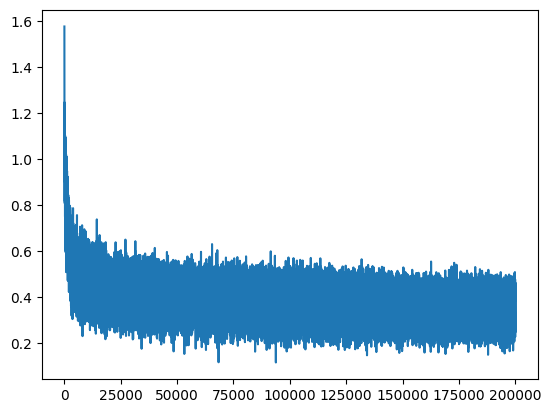

In [11]:
step_loss_plot = plt.plot(stepi, lossi)
step_loss_plot

In [12]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * feature_size) @ W1 + b1)
logits = h @ W2 + b2
training_loss = F.cross_entropy(logits, Ytr).item()
print(f"{training_loss=}")

training_loss=2.231363534927368


In [13]:
emb = C[Xde]
h = torch.tanh(emb.view(-1, block_size * feature_size) @ W1 + b1)
logits = h @ W2 + b2
validation_loss = F.cross_entropy(logits, Yde).item()
print(f"{validation_loss=}")

validation_loss=2.2888095378875732


In [14]:
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

teo.


cay.
favi.
kalas.
evan.
talab.
lucien.
nor.
brad.
day.
guoc.
tyora.
dylinglora.
raleigh.
paytyn.
aasirlacharrianna.
blakihamisa.
neas.
trita.
nilar.


In [15]:
import json

save_name = "weights=400"

results = {
    "description": "Testing model performance keeping learning rate constant.",
    "settings": {
        "block_size": block_size,
        "feature_size": feature_size,
        "num_of_weights": num_of_weights,
        "iterations": iterations,
        "lr_init": lr_init,
        "decay_rate_range": decay_rate_range,
        "decay_rate_value": decay_rate_value,
        "batch_size": batch_size,
    },
    "results": {
        "training_loss": float(f"{training_loss:.5f}"),
        "validation loss": float(f"{validation_loss:.5f}"),
        "time_taken": float(f"{(end - start):.5f}"),
    },
}

with open(f"results/{save_name}.json", "w") as save_file:
    json.dump(results, save_file)